In [29]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

np.random.seed(1)

get_px = lambda x: web.DataReader(x, 'google', start='2015-01-01', end='2017-01-01')['Close']

symbols = ['SPY','TLT','MSFT']
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
lrets = np.log(data/data.shift(1)).dropna()

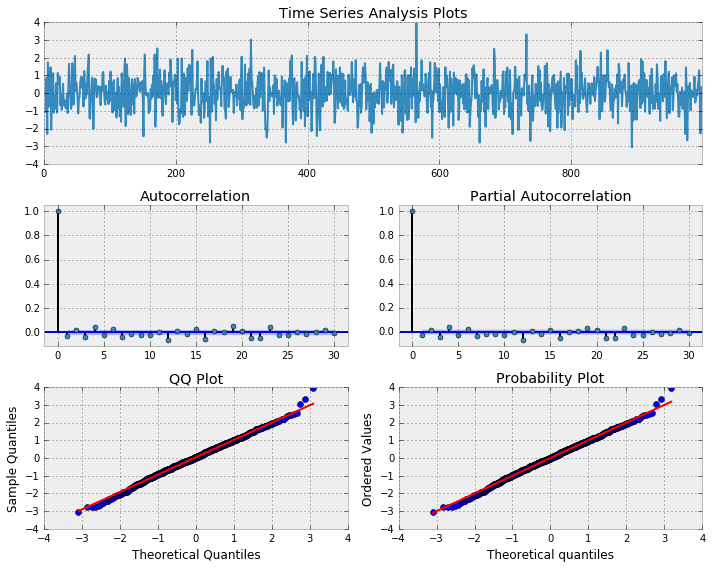

In [30]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

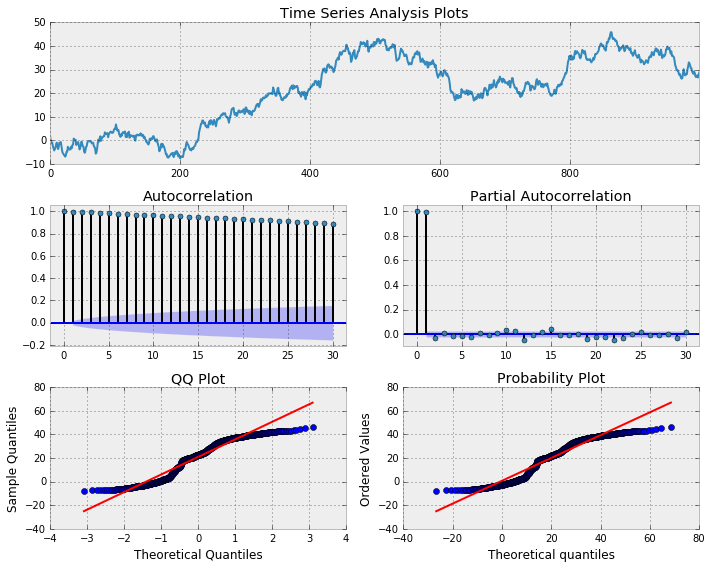

In [31]:
n_samples = 1000
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]
tsplot(x, lags=30)

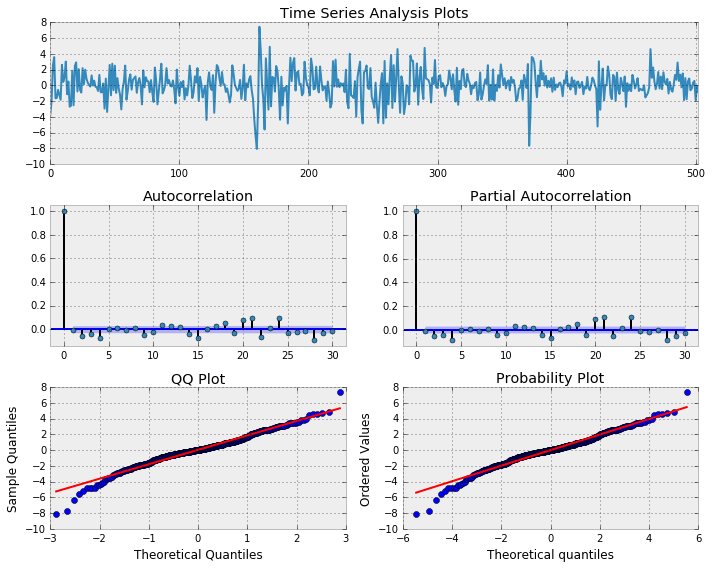

In [32]:
tsplot(np.diff(data.SPY), lags=30)

## Autoregressive Models - AR(p)

In [33]:
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')
true_order = 1
print('alpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('true alpha = {} | true order = {}'.format(a, true_order))

alpha estimate: 0.58100 | best lag order = 1
true alpha = 0.6 | true order = 1


coef estimate: 0.6691 -0.3391 | best lag order = 2
true coefs = [0.666, -0.333] | true order = 2


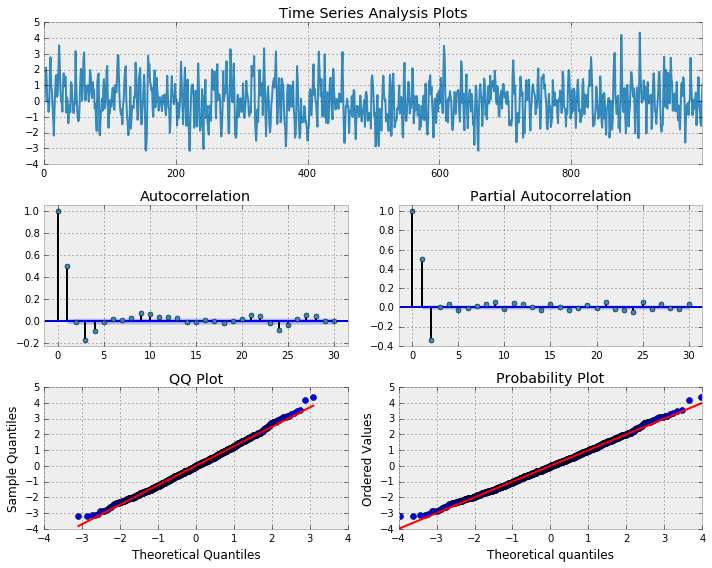

In [34]:
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('coef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('true coefs = {} | true order = {}'.format([.666,-.333], true_order))

In [35]:
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(maxlag=max_lag, ic='aic', trend='nc')
print('best estimated lag order = {}'.format(est_order))

best estimated lag order = 1


## Moving Average Models - MA(q)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1438.725
Method:                           mle   S.D. of innovations              1.020
Date:                Sat, 08 Jul 2017   AIC                           2881.451
Time:                        15:43:33   BIC                           2891.266
Sample:                             0   HQIC                          2885.182
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6214      0.024     26.074      0.000       0.575       0.668
                                    Roots                                    
                 Real           Imaginary           M

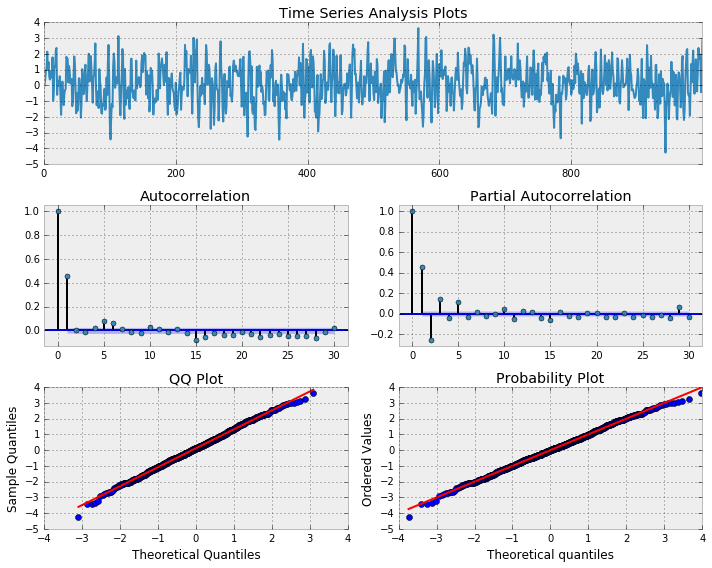

In [36]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
tsplot(ma1, lags=30)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1408.322
Method:                           mle   S.D. of innovations              0.989
Date:                Sat, 08 Jul 2017   AIC                           2824.645
Time:                        15:43:34   BIC                           2844.276
Sample:                             0   HQIC                          2832.106
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5686      0.032     18.050      0.000       0.507       0.630
ma.L2.y        0.3400      0.036      9.449      0.000       0.269       0.411
ma.L3.y        0.1234      0.030      4.151      0.0

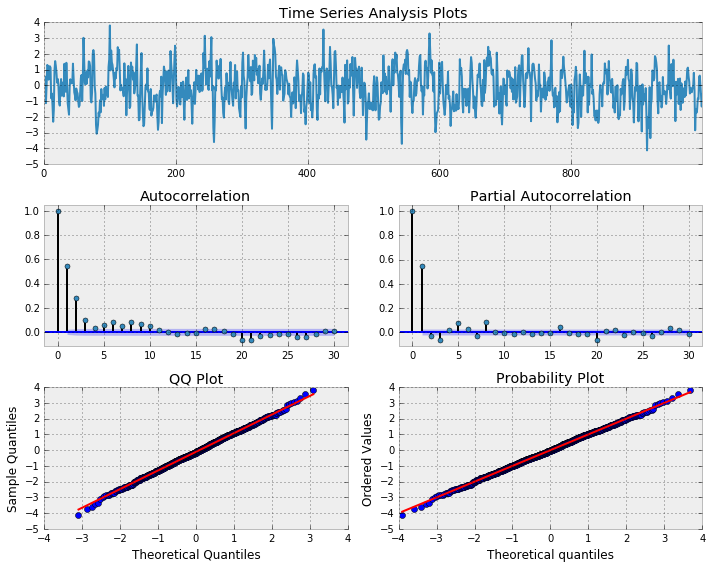

In [37]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
max_lag = 30
md3 = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
print(md3.summary())
tsplot(ma3, lags=30)

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                  390
Model:                     ARMA(0, 3)   Log Likelihood                1279.787
Method:                           mle   S.D. of innovations              0.009
Date:                Sat, 08 Jul 2017   AIC                          -2551.574
Time:                        15:43:35   BIC                          -2535.709
Sample:                    01-05-2015   HQIC                         -2545.285
                         - 12-30-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0224      0.052     -0.433      0.665      -0.124       0.079
ma.L2.SPY     -0.0408      0.058     -0.702      0.483      -0.155       0.073
ma.L3.SPY     -0.0508      0.053     -0.959      0.3

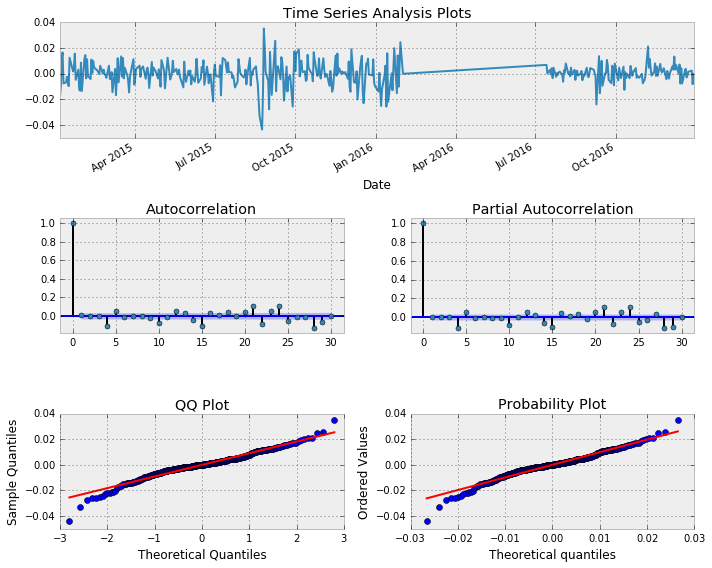

In [38]:
Y = lrets.SPY
md4 = smt.ARMA(Y, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
print(md4.summary())
tsplot(md4.resid, lags=30)

## Autoregressive Moving Average Models - ARMA(p, q)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7064.968
Method:                           mle   S.D. of innovations              0.994
Date:                Sat, 08 Jul 2017   AIC                          14139.937
Time:                        15:43:37   BIC                          14172.523
Sample:                             0   HQIC                         14151.358
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4551      0.060      7.628      0.000       0.338       0.572
ar.L2.y       -0.2276      0.015    -14.740      0.000      -0.258      -0.197
ma.L1.y        0.5179      0.061      8.548      0.0

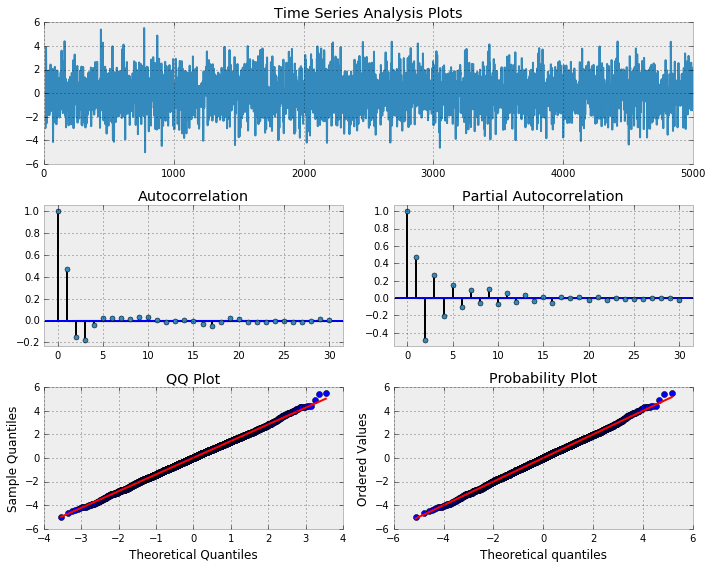

In [39]:
n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit
alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)
mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=30, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 14233.56057 | order: (3, 2)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7110.780
Method:                           mle   S.D. of innovations              1.003
Date:                Sat, 08 Jul 2017   AIC                          14233.561
Time:                        15:43:58   BIC                          14272.664
Sample:                             0   HQIC                         14247.266
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5351      0.028     19.321      0.000       0.481       0.589
ar.L2.y       -0.2747      0.016    -17.295      0.000      -0.306      -0.244
ar.L3.y        0.42

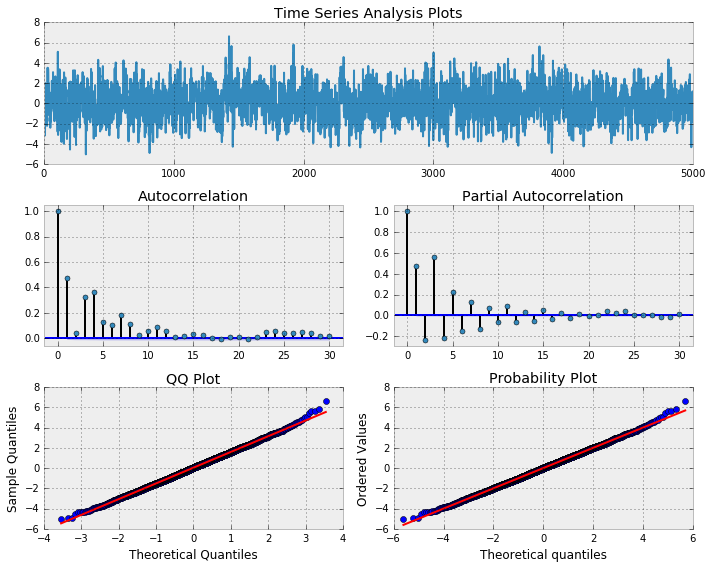

In [40]:
max_lag = 30
n = int(5000)
burn = 2000
alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for j in xrange(5):
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())

In [41]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for j in xrange(5):
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())

/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()


aic: -2554.80815 | order: (4, 0)
                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                  390
Model:                     ARMA(4, 0)   Log Likelihood                1282.404
Method:                           mle   S.D. of innovations              0.009
Date:                Sat, 08 Jul 2017   AIC                          -2554.808
Time:                        15:44:00   BIC                          -2534.977
Sample:                    01-05-2015   HQIC                         -2546.947
                         - 12-30-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.0151      0.050     -0.299      0.765      -0.114       0.084
ar.L2.SPY     -0.0396      0.050     -0.784      0.433      -0.138       0.059
ar.L3.SPY     -0.05

## Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -2554.80815 | order: (4, 0, 0)
                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                  390
Model:                     ARMA(4, 0)   Log Likelihood                1282.404
Method:                           mle   S.D. of innovations              0.009
Date:                Sat, 08 Jul 2017   AIC                          -2554.808
Time:                        15:46:45   BIC                          -2534.977
Sample:                    01-05-2015   HQIC                         -2546.947
                         - 12-30-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.0151      0.050     -0.299      0.765      -0.114       0.084
ar.L2.SPY     -0.0396      0.050     -0.784      0.433      -0.138       0.059
ar.L3.SPY     -0

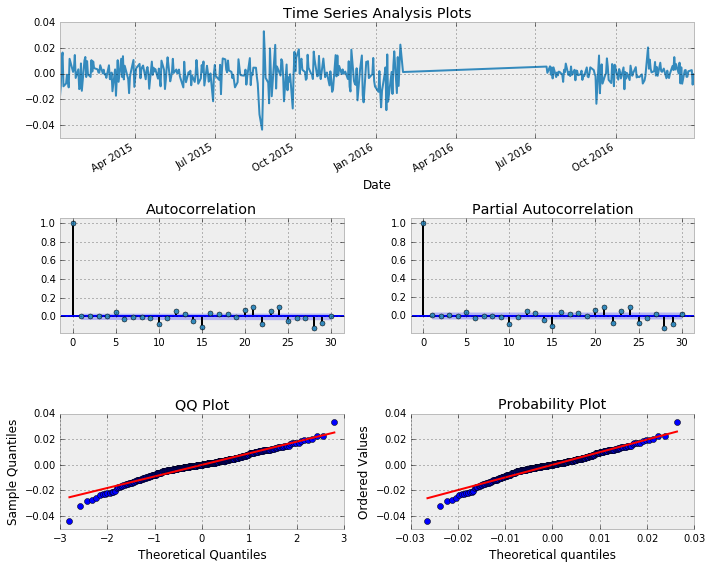

In [43]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for d in xrange(2):
        for j in xrange(5):
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
tsplot(best_mdl.resid, lags=30)
print(best_mdl.summary())

In [44]:
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2016-12-30,0.000201,-0.017497,-0.023058,0.017899,0.023460
2016-12-31,0.001135,-0.016565,-0.022127,0.018835,0.024396
2017-01-01,0.000191,-0.017522,-0.023088,0.017905,0.023471
2017-01-02,0.000375,-0.017361,-0.022935,0.018111,0.023684
2017-01-03,-0.000096,-0.017949,-0.023558,0.017757,0.023367


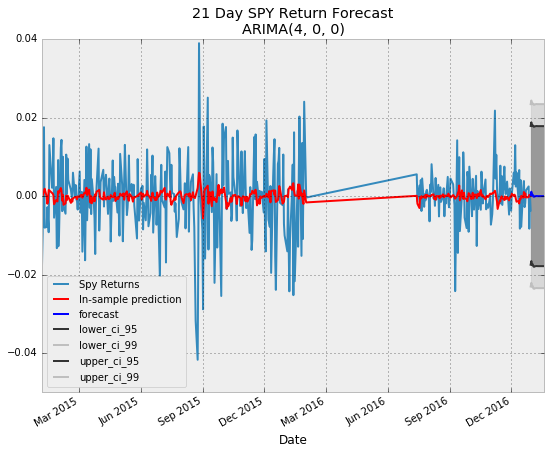

In [45]:
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)